# DA10 Epoching
06/26/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'DA10'
subj_format = ['nlx']
subj_site = ['UCD']


### Import Preprocessed Data

In [85]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [86]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 41 x 1585280 (3170.6 s), ~495.9 MB, data loaded>

In [87]:
photodiode_data

<Raw | photodiode.fif, 1 x 1585280 (3170.6 s), ~12.1 MB, data loaded>

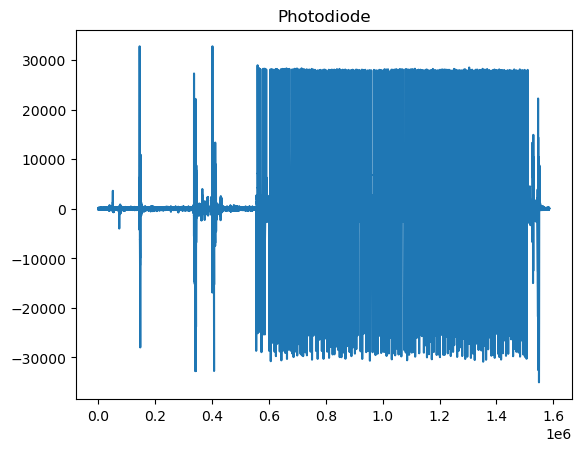

In [88]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

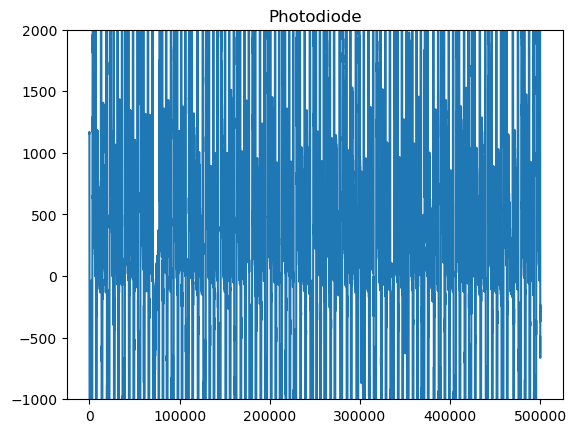

In [89]:

# Sanity check the photodiode
plt.plot(photodiode_data._data[0,1000000:1500000])
plt.title("Photodiode")
plt.ylim(-1000,2000)
plt.show()

### Load Anat Recon Info 


In [14]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination
0,LAD1,rHipp_L,-14.399994,7.691510,-14.025760,-14.342856,-5.763441,-22.991499,Gray,Left PHG parahippocampal gyrus,Amygdala (LB),L ParaHippocampal Gyrus,L Hipp,Left parahippocampal gyrus A,NaN
1,LAD2,rHipp_L,-19.599993,7.291924,-14.025760,-20.094629,-6.129953,-22.869272,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Hipp,Left amygdala inferior,NaN
2,LAD3,rHipp_L,-24.799993,6.892338,-13.626463,-25.843869,-6.282030,-22.239514,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Hipp,Left amygdala inferior,NaN
3,LAD4,lAmyg_L,-29.599993,6.892338,-13.626463,-31.162715,-6.120036,-22.229235,Gray,Left Amygdala,Amygdala (LB),L Hippocampus,L Amyg,Left amygdala inferior,NaN
4,LAD5,Unknown,-34.799992,6.492752,-13.227165,-36.913993,-6.484951,-21.801391,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM
5,LAD6,Unknown,-39.599992,6.093167,-13.227165,-42.078518,-7.123732,-21.935039,White,Left Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM
6,LAD7,aSTS_L,-44.799992,6.093167,-13.227165,-47.687519,-7.375745,-22.114078,White,Left Cerebral White Matter,Unknown,L Middle Temporal Gyrus,L MTG,Left superior middle temporal gyrus A,WM
7,LAD8,aSTS_L,-49.599992,5.693581,-12.827868,-52.874503,-7.931650,-21.592201,White,Left MTG middle temporal gyrus,Unknown,L Middle Temporal Gyrus,L MTG,Left superior middle temporal gyrus A,WM
8,LAD9,A21r_L,-54.799991,5.693581,-12.827868,-58.525474,-8.184515,-21.581147,White,Left MTG middle temporal gyrus,Unknown,L Middle Temporal Gyrus,L MTG,Left inferior middle temporal gyrus A,NaN
9,LHB1,cHipp_L,-26.399993,-14.685300,-10.432084,-26.654716,-29.075918,-14.281852,Gray,Left Hippocampus,Subiculum,L ParaHippocampal Gyrus,L Hipp,Left hippocampus body,NaN


## Load behavior

In [15]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,128.0,loss,379.009074,379.012221,382.610063,384.626795,3.597842,-0.4,-1.44,...,-1.148452,0.282562,0.717438,0.000000,-1.148452,-0.304645,-1.148452,-0.304645,0.000000,0.000000
1,2,45.0,mix,390.119682,390.129793,392.605504,394.622769,2.475711,0.0,-1.10,...,-0.930400,0.279746,0.720254,-0.621199,-1.551599,-0.930400,-1.551599,-0.930400,0.000000,0.000000
2,3,84.0,gain,399.331027,399.331819,404.150264,406.167212,4.818446,0.5,0.00,...,0.000000,0.470099,0.529901,0.000000,0.000000,-0.039151,0.000000,0.000000,0.542503,-0.039151
3,4,42.0,mix,416.845493,416.846275,419.177541,419.185403,2.331266,0.0,-0.80,...,-0.725352,0.388176,0.611824,0.000000,0.725352,0.725352,0.000000,0.000000,0.725352,0.725352
4,5,104.0,loss,426.424513,426.425352,429.622041,431.638676,3.196689,-0.2,-0.44,...,-0.454541,0.527700,0.472300,0.454541,0.000000,0.490803,0.000000,0.000000,0.454541,0.490803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,1.0,mix,2143.138202,2143.148032,2146.361413,2146.369284,3.213381,0.0,-0.30,...,-0.336930,0.297133,0.702867,0.000000,0.336930,0.336930,0.000000,0.000000,0.336930,0.336930
146,147,57.0,gain,2153.065555,2153.073785,2156.141033,2158.157286,3.067248,0.2,0.00,...,0.000000,0.548975,0.451025,0.000000,0.000000,0.064255,0.000000,0.000000,0.348418,0.064255
147,148,72.0,gain,2166.769473,2166.776112,2170.200739,2170.208657,3.424626,0.4,0.00,...,0.000000,0.425924,0.574076,0.000000,0.488543,0.488543,0.000000,0.000000,0.488543,0.488543
148,149,62.0,gain,2177.524504,2177.532319,2181.296300,2183.312601,3.763981,0.3,0.00,...,0.000000,0.441525,0.558475,-0.313324,-0.313324,-0.390149,-0.313324,-0.390149,0.000000,0.000000


In [19]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [93]:
test_photo = photodiode_data

In [97]:
np.nanmax(photodiode_data._data)

2280.98046875

In [94]:
test_photo._data = np.abs(test_photo._data[0, :])-np.nanmax(test_photo._data[0, :]) #consider resaving photodiode 

In [106]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=0.3)

26 blocks
..........................

found matches for 0 of 395 pulses


IndexError: index 0 is out of bounds for axis 0 with size 0

In [98]:
print(slope,offset)

1.0563337816406366 1022.4345510405615


In [107]:
slope=0.9999991556190556 #this worked but I can't recreate it...
offset=822.6778105046562

## Make epochs

In [56]:
np.where(behav_df['FeedbackOnset']==0)

(array([9]),)

In [57]:
behav_df = behav_df.drop(9,axis=0)

In [58]:
behav_df.iloc[9,]

Round                     11
Trial Num              123.0
TrialType               loss
TrialOnset        504.301396
ChoiceOnset       504.302214
DecisionOnset     506.604438
FeedbackOnset     508.620506
RT                  2.302224
SafeBet                 -0.4
LowBet                  -0.8
HighBet                  0.0
HighBetPos            bottom
GamblePos              right
ChoicePos              right
GambleChoice          gamble
Outcome                  bad
Profit                  -0.8
TotalProfit             7.67
GambleEV                -0.4
CR                       0.0
choiceEV                -0.4
RPE                     -0.4
totalCPE                -0.8
decisionCPE             -0.4
totalRegret             -0.8
decisionRegret          -0.4
totalRelief              0.0
decisionRelief           0.0
util_g             -0.725352
util_s             -0.843807
p_g                 0.589599
p_s                 0.410401
Name: 10, dtype: object

In [23]:
beh_ts = behav_df['TrialOnset']

In [24]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [27]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [28]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [29]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=2, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 5562 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 6150 out of 6150 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 out of  41 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 6150 out of 6150 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: D

Should quality check IED removal in epoched data here ...

### Add metadata to epochs

In [30]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    
    

In [31]:
epochs_all_evs[event].metadata

,ltpo1,lof6,lof7,ltpo3,ltpo2,lof5,ltpo8,ltpo5,lhb7,lof8,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.720,-0.720,-1.44,-1.04,-1.44,-1.04,0.00,0.00,-1.148452,-0.843807
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.110,-1.210,-2.42,-1.10,-2.42,-1.10,0.00,0.00,-0.309200,0.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.555,0.555,0.00,0.61,0.00,0.00,1.11,0.61,0.542503,0.581653
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-1.20,-1.20,0.00,0.00,0.80,0.80,-0.148756,0.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.220,0.220,0.00,0.20,0.00,0.00,0.44,0.20,-0.454541,-0.490803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.06,-0.06,0.00,0.00,0.30,0.30,-0.281497,0.000000
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.315,0.315,0.00,0.43,0.00,0.00,0.63,0.43,0.348418,0.284163
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.33,-0.33,0.00,0.00,0.40,0.40,0.390949,0.488543
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.275,-0.275,-0.55,-0.30,-0.55,-0.30,0.00,0.00,0.313324,0.390149


### Save epoched data

In [32]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)